<a href="https://colab.research.google.com/github/Dhairya-Arora01/Cardio-disease-predictor/blob/main/cardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [3]:
data = pd.read_csv('drive/MyDrive/cardio_train.csv', sep=";")

In [4]:
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


id is of no use

In [5]:
data = data.drop(columns=['id'])

In [6]:
data.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## EDA

In [7]:
data.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
print(data[data['ap_hi']<=0]['ap_hi'].count())
print(data[data['ap_lo']<=0]['ap_lo'].count())

7
22


Systolic and Disystolic pressure can't be negative. So need to remove these entries

In [9]:
data[data['ap_hi']<=0]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
4607,15281,1,165,78.0,-100,80,2,1,0,0,1,0
16021,22108,2,161,90.0,-115,70,1,1,0,0,1,0
20536,15581,1,153,54.0,-100,70,1,1,0,0,1,0
23988,18301,1,162,74.0,-140,90,1,1,0,0,1,1
25240,14711,2,168,50.0,-120,80,2,1,0,0,0,1
35040,23325,2,168,59.0,-150,80,1,1,0,0,1,1
46627,23646,2,160,59.0,-120,80,1,1,0,0,0,0


In [10]:
data = data.drop(data[(data['ap_hi']<=0) | (data['ap_lo']<=0) | (data['ap_hi'] < data['ap_lo'])].index)

In [11]:
data.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000,68744.000000
mean,19464.158850,1.348583,164.359857,74.116847,128.775297,81.272795,1.364686,1.225620,0.087877,0.053343,0.803416,0.494821
std,2468.210782,0.476525,8.190841,14.331747,155.059640,9.573730,0.678893,0.571479,0.283118,0.224718,0.397418,0.499977
min,10798.000000,1.000000,55.000000,11.000000,16.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17657.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19701.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21324.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,182.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
data['cardio'].value_counts()

0    34728
1    34016
Name: cardio, dtype: int64

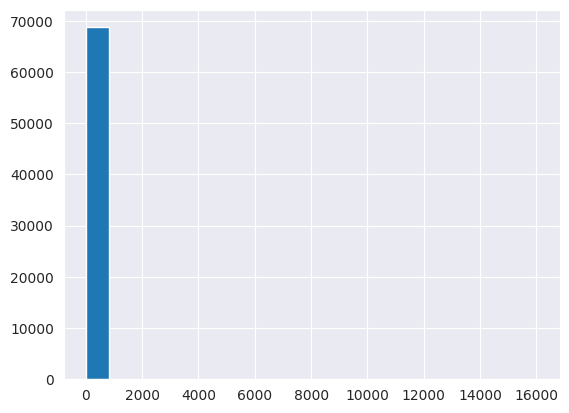

In [13]:
plt.hist(data['ap_hi'], bins=20)
plt.show()

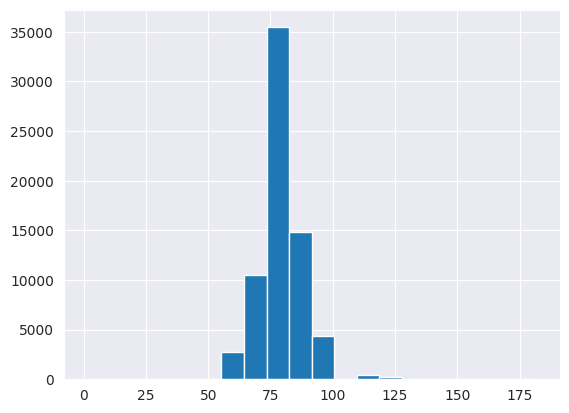

In [14]:
plt.hist(data['ap_lo'], bins=20)
plt.show()

It seems that the data is filled with outliers lets say by plotting box plots for each of the numerical feature

In [15]:
num_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

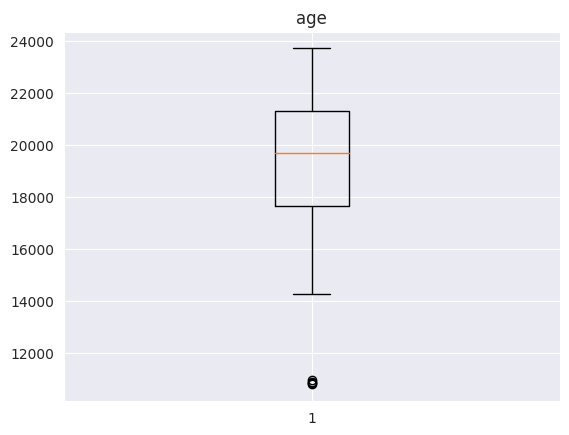

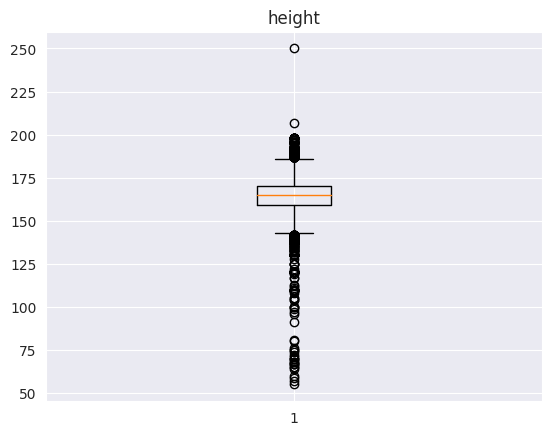

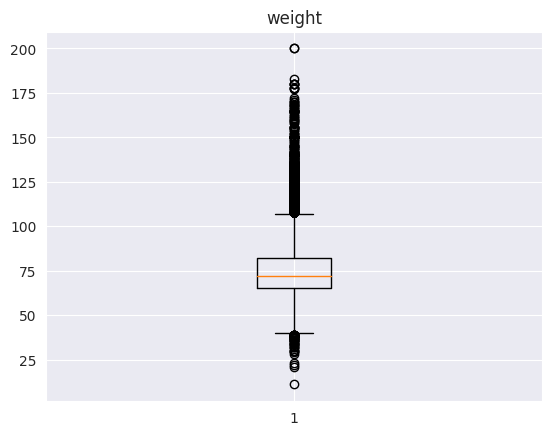

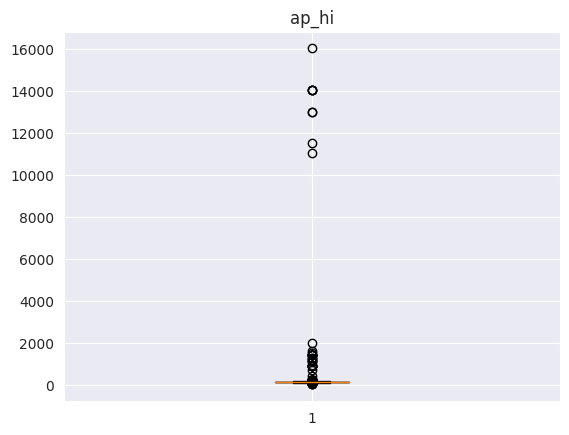

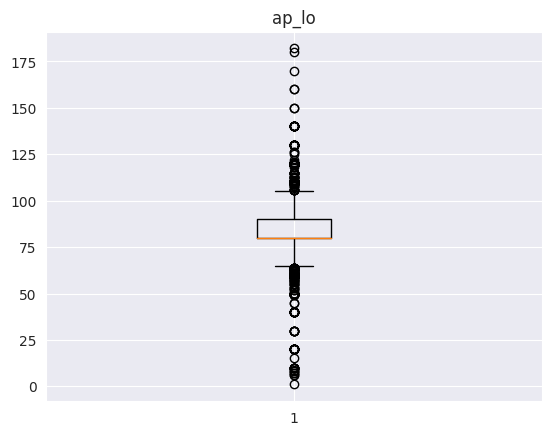

In [16]:
for feature in num_features:
  plt.boxplot(data[feature])
  plt.title(feature)
  plt.show()

Definitely ap_hi and ap_lo values are non-sensical. Lets calculate the z-score and by convention values more or less than 2 and -2 can be considered as outliers.

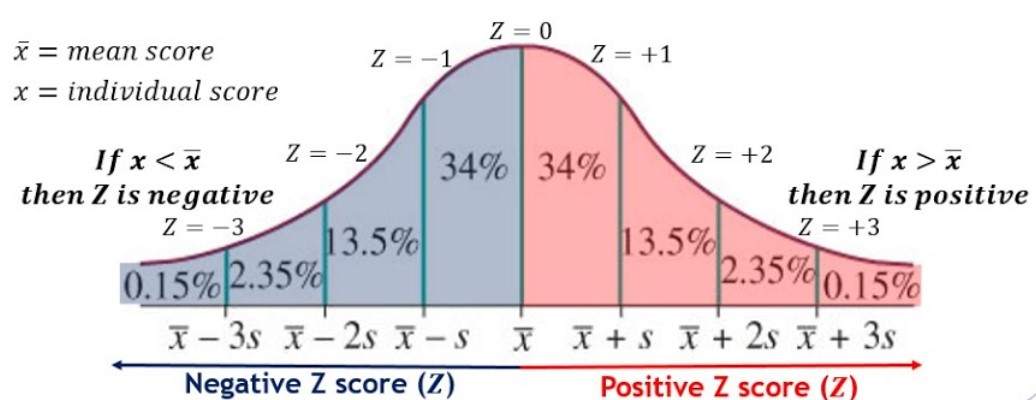

### Removing outliers

In [17]:
data = data[(stats.zscore(data['ap_hi']) > -2) & (stats.zscore(data['ap_hi']) < 2) & (stats.zscore(data['ap_lo']) > -2) & (stats.zscore(data['ap_lo']) < 2)]
data.shape

(65148, 12)

## Preprocessing

In [18]:
y = data['cardio']
X = data.drop(columns=['cardio'])

In [19]:
print(X.shape, y.shape)

(65148, 11) (65148,)


### Splitting the data

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=28)

### Scaling the numerical features

In [21]:
ct = ColumnTransformer([
    ('scaler', MinMaxScaler(), [i for i in range(6)]),
    ('passthrough', 'passthrough', [i for i in range(6, 11)])
])

X_train_scaled = ct.fit_transform(X_train)
X_test_scaled = ct.transform(X_test)

## Baseline Model

In [22]:
lr = LogisticRegression(random_state=28)
lr.fit(X_train_scaled, y_train)

LogisticRegression(random_state=28)

In [69]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
  print("Training set")
  print(classification_report(y_train, model.predict(X_train)))
  print("ROC_AUC score", roc_auc_score(y_train, model.predict(X_train)))
  train_plot = ConfusionMatrixDisplay(confusion_matrix(y_train, model.predict(X_train)))
  train_plot.plot()
  plt.show()
  print("----------------")
  print("Test Set")
  print(classification_report(y_test, model.predict(X_test)))
  print("ROC_AUC score", roc_auc_score(y_test, model.predict(X_test)))
  test_plot = ConfusionMatrixDisplay(confusion_matrix(y_test, model.predict(X_test)))
  test_plot.plot()
  plt.show()

Training set
              precision    recall  f1-score   support

           0       0.70      0.78      0.74     24256
           1       0.75      0.67      0.71     24605

    accuracy                           0.72     48861
   macro avg       0.73      0.73      0.72     48861
weighted avg       0.73      0.72      0.72     48861



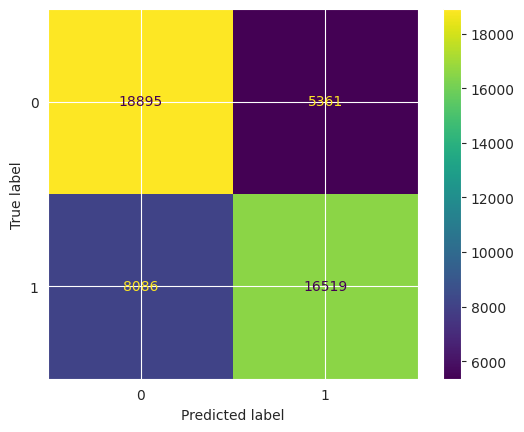

----------------
Test Set
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      8196
           1       0.75      0.67      0.70      8091

    accuracy                           0.72     16287
   macro avg       0.73      0.72      0.72     16287
weighted avg       0.73      0.72      0.72     16287



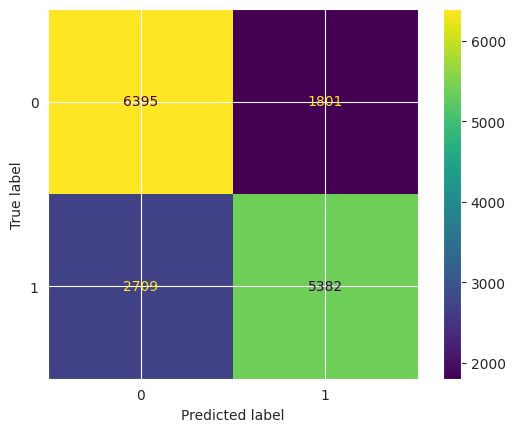

In [24]:
evaluate_model(lr, X_train_scaled, X_test_scaled, y_train, y_test)

### HPT

In [25]:
# lr_param_grid = {
#     'tol': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
#     'C': [1, 10, 50],
#     'solver': [ 'newton-cg', 'sag', 'saga', 'lbfgs'],
#     'max_iter': [100, 250, 500]
# }

In [26]:
# lr_grid = GridSearchCV(LogisticRegression(random_state=28), cv=5, param_grid=lr_param_grid, scoring='accuracy', return_train_score=True)
# lr_grid.fit(X_train_scaled, y_train)

In [27]:
# lr_grid.best_score_

In [28]:
# lr_grid.best_estimator_

In [29]:
lr_best = LogisticRegression(C=1, solver='saga', tol=0.001, random_state=28)
lr_best.fit(X_train_scaled, y_train)

LogisticRegression(C=1, random_state=28, solver='saga', tol=0.001)

Training set
              precision    recall  f1-score   support

           0       0.70      0.78      0.74     24256
           1       0.75      0.67      0.71     24605

    accuracy                           0.72     48861
   macro avg       0.73      0.73      0.72     48861
weighted avg       0.73      0.72      0.72     48861



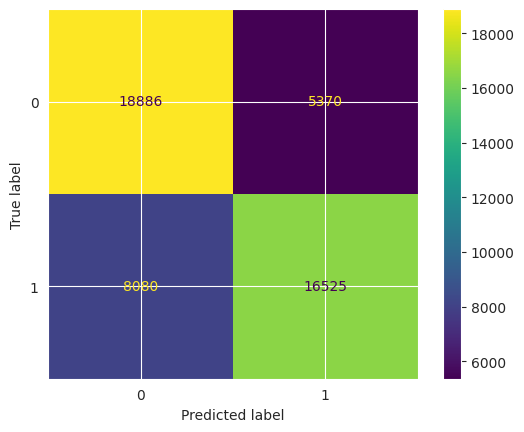

----------------
Test Set
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      8196
           1       0.75      0.67      0.70      8091

    accuracy                           0.72     16287
   macro avg       0.73      0.72      0.72     16287
weighted avg       0.73      0.72      0.72     16287



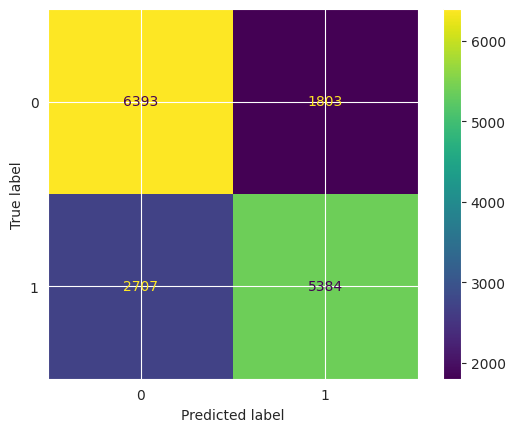

In [30]:
evaluate_model(lr_best, X_train_scaled, X_test_scaled, y_train, y_test)

Exactly the same

## DecisionTreeClassifier

In [36]:
dtree = DecisionTreeClassifier(random_state=28)
dtree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=28)

Training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24256
           1       1.00      1.00      1.00     24605

    accuracy                           1.00     48861
   macro avg       1.00      1.00      1.00     48861
weighted avg       1.00      1.00      1.00     48861



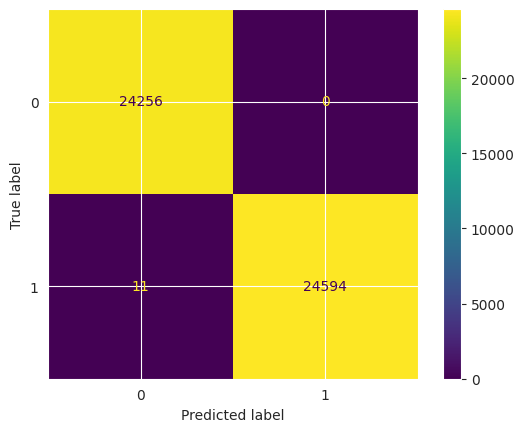

----------------
Test Set
              precision    recall  f1-score   support

           0       0.63      0.62      0.63      8196
           1       0.62      0.63      0.63      8091

    accuracy                           0.63     16287
   macro avg       0.63      0.63      0.63     16287
weighted avg       0.63      0.63      0.63     16287



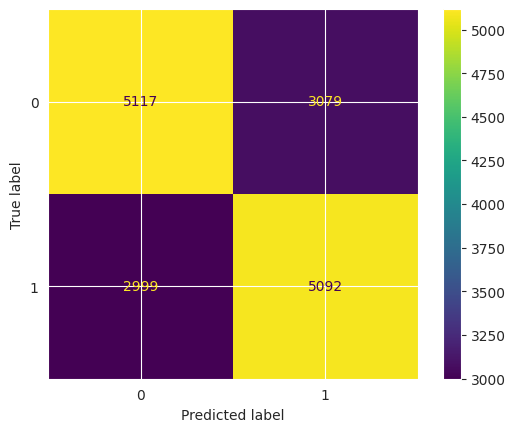

In [37]:
evaluate_model(dtree, X_train_scaled, X_test_scaled, y_train, y_test)

Overfitting

### HPT

In [41]:
dtree_param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [i for i in range(1, 21, 5)],
    'min_samples_split': [2, 4, 6]
}

In [42]:
dtree_grid = GridSearchCV(DecisionTreeClassifier(random_state=28), dtree_param_grid, scoring="accuracy", n_jobs=-1, cv=5)
dtree_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=28), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [1, 6, 11, 16],
                         'min_samples_split': [2, 4, 6]},
             scoring='accuracy')

In [44]:
dtree_grid.best_estimator_

DecisionTreeClassifier(max_depth=6, random_state=28)

In [47]:
dtree_best = DecisionTreeClassifier(max_depth=6, random_state=28)
dtree_best.fit(X_train_scaled, y_train)

DecisionTreeClassifier(max_depth=6, random_state=28)

Training set
              precision    recall  f1-score   support

           0       0.70      0.79      0.74     24256
           1       0.76      0.67      0.72     24605

    accuracy                           0.73     48861
   macro avg       0.73      0.73      0.73     48861
weighted avg       0.73      0.73      0.73     48861



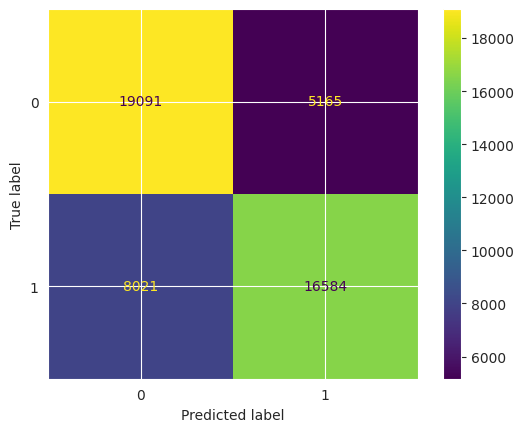

----------------
Test Set
              precision    recall  f1-score   support

           0       0.71      0.79      0.74      8196
           1       0.76      0.67      0.71      8091

    accuracy                           0.73     16287
   macro avg       0.73      0.73      0.73     16287
weighted avg       0.73      0.73      0.73     16287



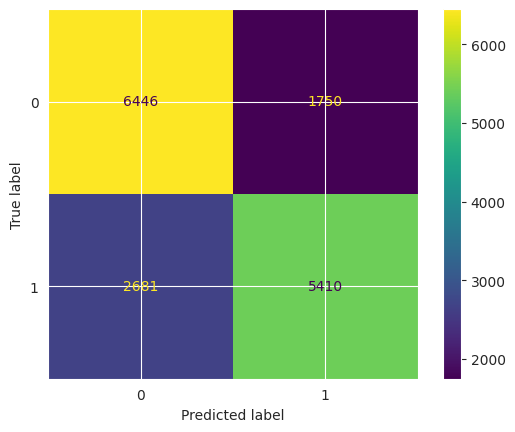

In [48]:
evaluate_model(dtree_best, X_train_scaled, X_test_scaled, y_train, y_test)

## RandomForestClassifier

In [49]:
rfc = RandomForestClassifier(random_state=28)
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=28)

Training set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24256
           1       1.00      1.00      1.00     24605

    accuracy                           1.00     48861
   macro avg       1.00      1.00      1.00     48861
weighted avg       1.00      1.00      1.00     48861

ROC_AUC score 0.9997140430611042


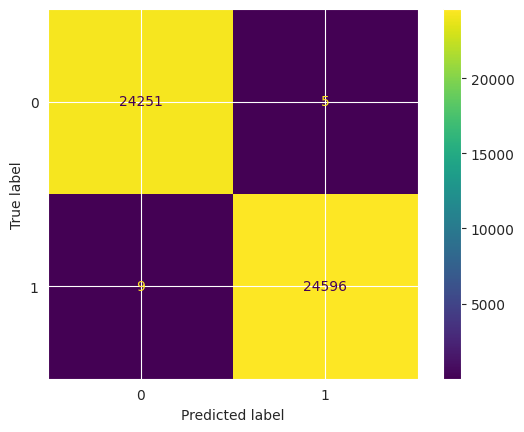

----------------
Test Set
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      8196
           1       0.71      0.70      0.71      8091

    accuracy                           0.71     16287
   macro avg       0.71      0.71      0.71     16287
weighted avg       0.71      0.71      0.71     16287

ROC_AUC score 0.7091682269745336


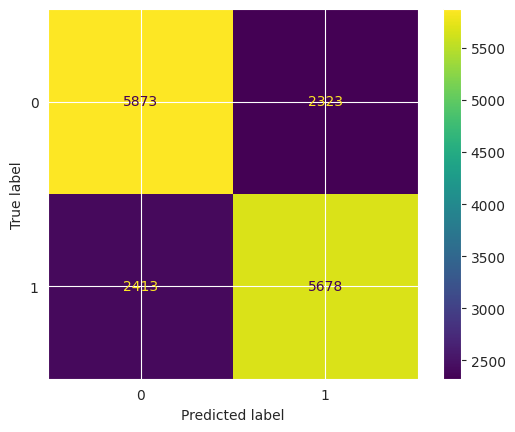

In [70]:
evaluate_model(rfc, X_train_scaled, X_test_scaled, y_train, y_test)

### HPT

In [56]:
rfc_param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 9, 12]
}

In [57]:
rfc_grid = GridSearchCV(RandomForestClassifier(random_state=28), rfc_param_grid, scoring="accuracy", cv=5, n_jobs=-1)
rfc_grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=28), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [6, 9, 12],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [58]:
rfc_grid.best_score_

0.7306031608465922

In [59]:
rfc_grid.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=200,
                       random_state=28)

In [63]:
rfc_best = RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=200, random_state=28)
rfc_best.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=12, n_estimators=200,
                       random_state=28)

Training set
              precision    recall  f1-score   support

           0       0.74      0.82      0.78     24256
           1       0.80      0.72      0.76     24605

    accuracy                           0.77     48861
   macro avg       0.77      0.77      0.77     48861
weighted avg       0.77      0.77      0.77     48861

ROC_AUC score 0.7694156424810153


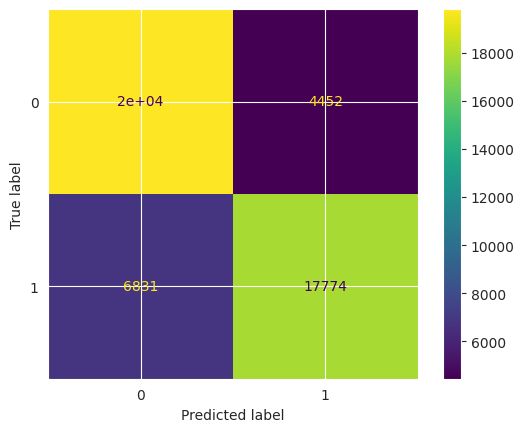

----------------
Test Set
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      8196
           1       0.75      0.69      0.72      8091

    accuracy                           0.73     16287
   macro avg       0.73      0.73      0.73     16287
weighted avg       0.73      0.73      0.73     16287

ROC_AUC score 0.732565041177832


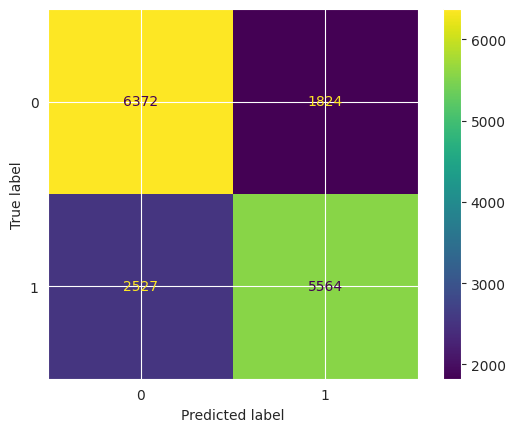

In [71]:
evaluate_model(rfc_best, X_train_scaled, X_test_scaled, y_train, y_test)

## XGBoost

In [79]:
xgb = XGBClassifier(booster='gbtree', learning_rate=0.05)
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Training set
              precision    recall  f1-score   support

           0       0.72      0.78      0.75     24256
           1       0.77      0.70      0.73     24605

    accuracy                           0.74     48861
   macro avg       0.74      0.74      0.74     48861
weighted avg       0.74      0.74      0.74     48861

ROC_AUC score 0.742564785316443


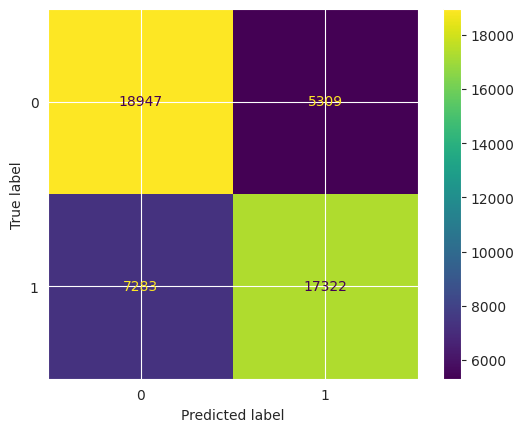

----------------
Test Set
              precision    recall  f1-score   support

           0       0.72      0.77      0.75      8196
           1       0.75      0.70      0.72      8091

    accuracy                           0.73     16287
   macro avg       0.74      0.73      0.73     16287
weighted avg       0.74      0.73      0.73     16287

ROC_AUC score 0.734567089438168


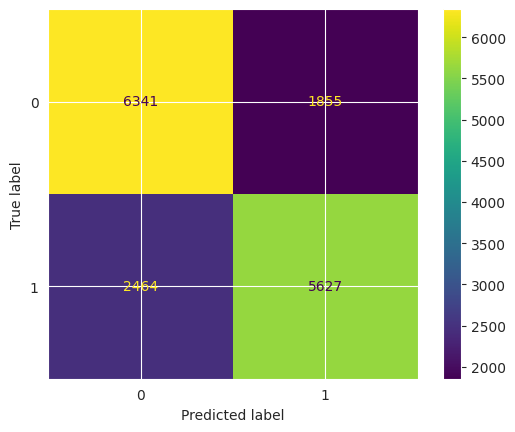

In [80]:
evaluate_model(xgb, X_train_scaled, X_test_scaled, y_train, y_test)